In [72]:
#Load libraries
import csv
from collections import Counter
import os
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import string
import nltk 
import seaborn as sns
import textmining
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.snowball import SnowballStemmer
import seaborn as sns

In [73]:
#Set working directory
os.chdir("D:\Edwisor\Pro1")

In [74]:
# Labels to be classified
target = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [75]:
# Load training dataset
train = pd.read_csv("train.csv")

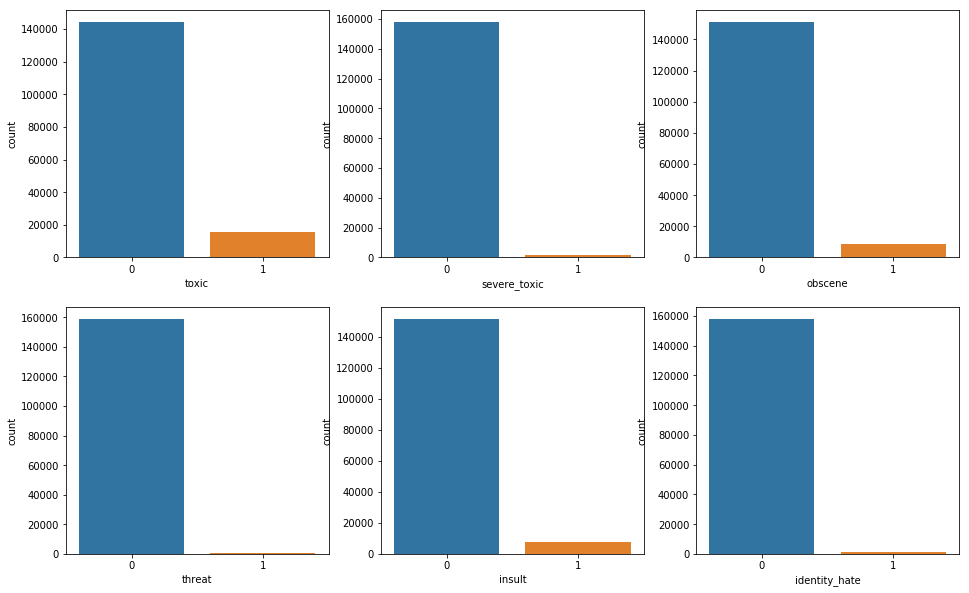

In [76]:
#Dataset vizualization 
fig,ax = plt.subplots(2,3,figsize=(16,10))
ax1,ax2,ax3,ax4,ax5,ax6 = ax.flatten()
sns.countplot(train['toxic'],ax=ax1)
sns.countplot(train['severe_toxic'],ax=ax2)
sns.countplot(train['obscene'],ax=ax3)
sns.countplot(train['threat'],ax = ax4)
sns.countplot(train['insult'],ax=ax5)
sns.countplot(train['identity_hate'], ax = ax6)

In [77]:
# Load testing dataset
test = pd.read_csv("test.csv")

In [78]:
#Removal of stopwords
sw = stopwords.words('english')
def stp(text):
    text = [text.lower() for text in text.split() if text.lower() not in sw]
    return " ".join(text)

In [79]:
train['comment_text'] = train['comment_text'].apply(stp)
test['comment_text'] = test['comment_text'].apply(stp)

In [80]:
# Removal of numbers,punctuation marks
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [81]:
cleaned_train_comment = []
for i in range(0,len(train)):
    cleaned_comment = clean_text(train['comment_text'][i])
    cleaned_train_comment.append(cleaned_comment)
train['comment_text'] = pd.Series(cleaned_train_comment).astype(str)

In [82]:
cleaned_test_comment = []
for i in range(0,len(test)):
    cleaned_comment = clean_text(test['comment_text'][i])
    cleaned_test_comment.append(cleaned_comment)
test['comment_text'] = pd.Series(cleaned_test_comment).astype(str)

In [83]:
#Stemming
stemmer = SnowballStemmer("english")
def stemming(text):
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text)

In [84]:
train['comment_text'] = train['comment_text'].apply(stemming)
test['comment_text'] = test['comment_text'].apply(stemming)

toxic


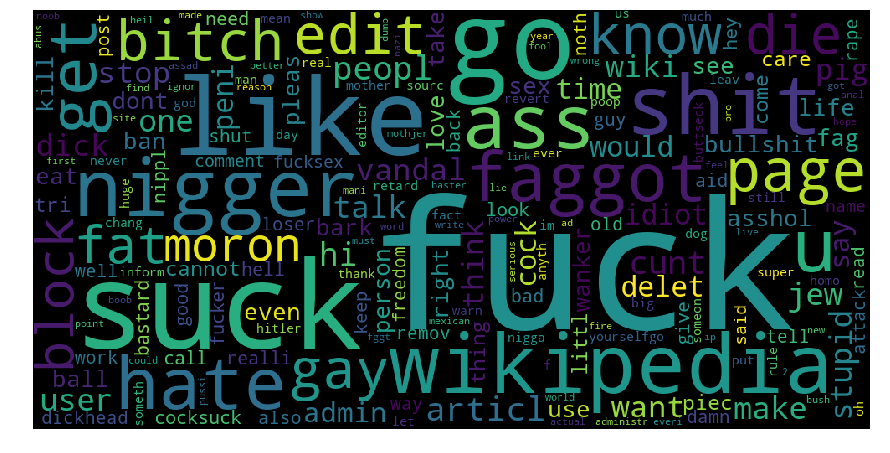

severe_toxic


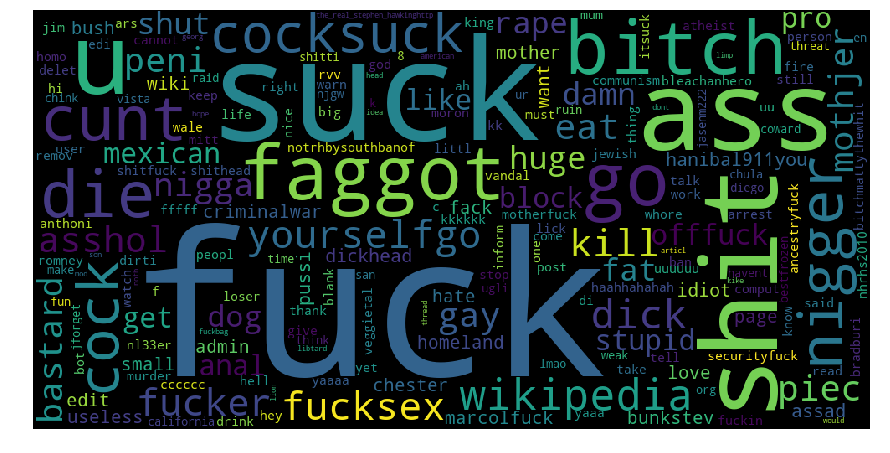

obscene


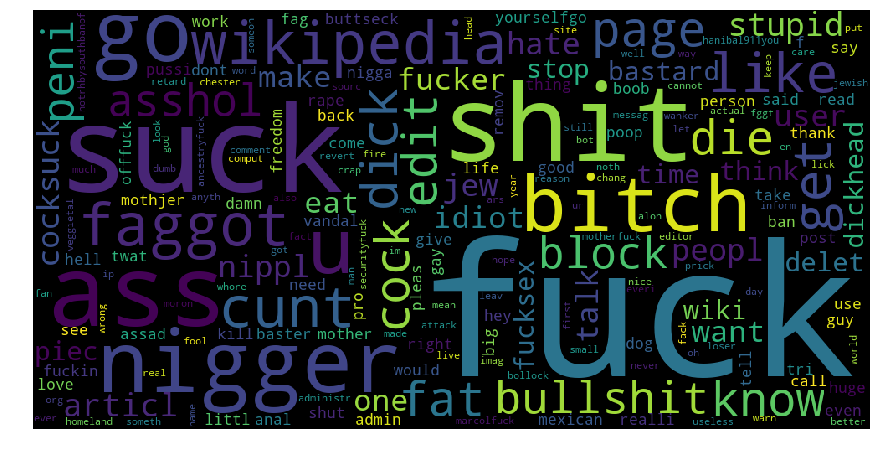

threat


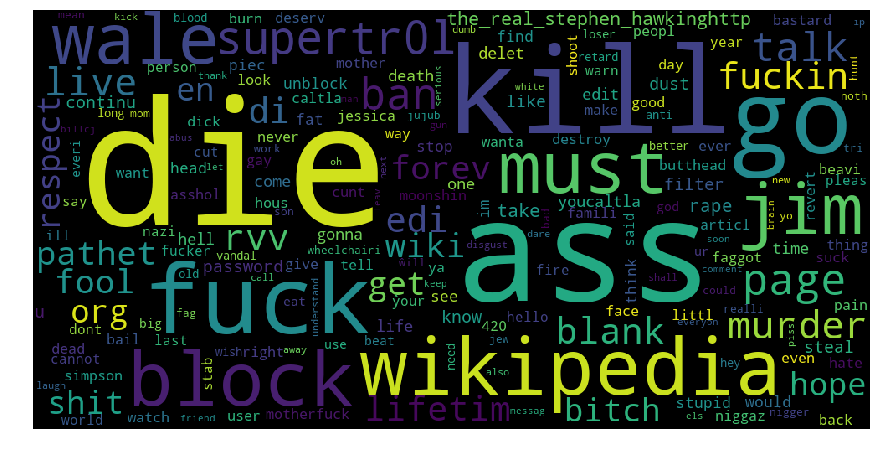

insult


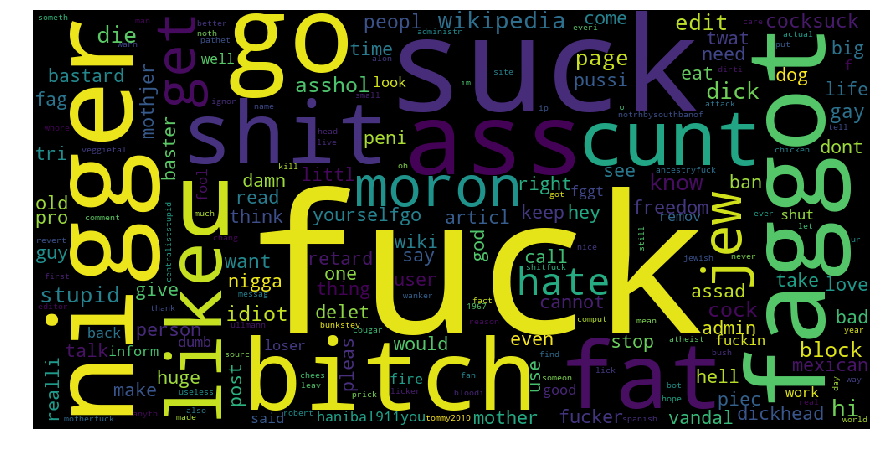

identity_hate


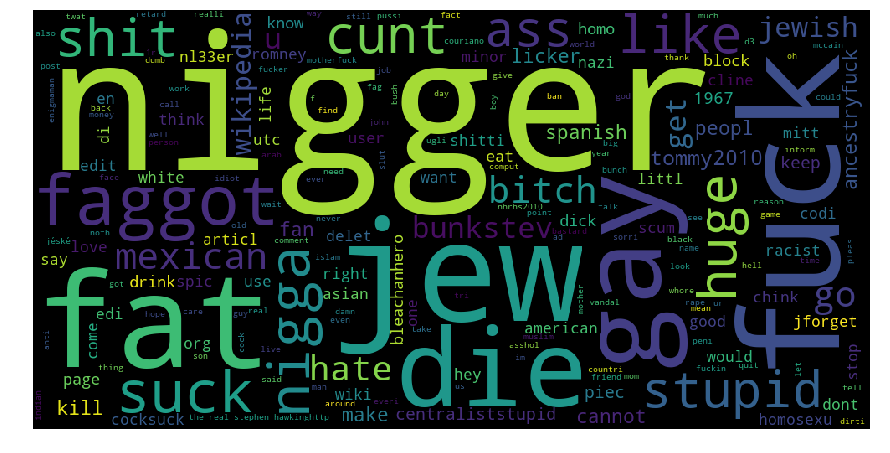

In [98]:
#WordCloud
word_counter = {}

def split_text(text):
    return ' '.join([word for word in text.split() if word not in (sw)])

for label in target:
  d = Counter()
  train[train[label] == 1]['comment_text'].apply(lambda t: d.update(split_text(t).split()))
  word_counter[label] = pd.DataFrame.from_dict(d, orient='index')\
                                        .rename(columns={0: 'count'})\
                                        .sort_values('count', ascending=False)
for label in target:
  print(label)
  wc = word_counter[label]
  wordcloud = WordCloud(width = 1000, height = 500,stopwords=STOPWORDS, background_color = 'black').generate_from_frequencies(
                         wc.to_dict()['count'])

  plt.figure(figsize = (15,8))
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()


In [99]:
#Sampling
from sklearn.cross_validation import train_test_split
col = train.columns.tolist()
X = train.comment_text
y = train[col[2:8]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=42)

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec_tf = TfidfVectorizer(stop_words='english',lowercase=True,
                max_features = 10000)
X_train_vec = vec_tf.fit_transform(X_train)
X_train_vec

<106912x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2373507 stored elements in Compressed Sparse Row format>

In [101]:
X_test_vec = vec_tf.transform(X_test)
X_full_test = vec_tf.transform(test.comment_text)
X_test_vec

<52659x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 1166300 stored elements in Compressed Sparse Row format>

In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report
lr = LogisticRegression()

# create submission file
submission = pd.read_csv("sample_submission.csv")

for label in target:
    print('Processing {}'.format(label))
    lr.fit(X_train_vec, y_train[label])
    y_pred1 = lr.predict(X_test_vec)
    print('Training accuracy is         {}'.format(accuracy_score(y_test[label], y_pred1)*100))
    test_y_prob = lr.predict_proba(X_full_test)[:,1]
    print(classification_report(y_test[label], y_pred1))
    submission[label] = test_y_prob
    submission.to_csv('submission.csv', index=False)

Processing toxic
             precision    recall  f1-score   support

          0       0.96      0.99      0.98     47576
          1       0.92      0.61      0.73      5083

avg / total       0.96      0.96      0.95     52659

Processing severe_toxic
             precision    recall  f1-score   support

          0       0.99      1.00      1.00     52133
          1       0.59      0.25      0.35       526

avg / total       0.99      0.99      0.99     52659

Processing obscene
             precision    recall  f1-score   support

          0       0.98      1.00      0.99     49828
          1       0.92      0.64      0.75      2831

avg / total       0.98      0.98      0.98     52659

Processing threat
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     52507
          1       0.72      0.12      0.20       152

avg / total       1.00      1.00      1.00     52659

Processing insult
             precision    recall  f1-score  

In [104]:
nb=MultinomialNB()

# create submission file
submission = pd.read_csv("sample_submission.csv")

for label in target:
    print('Processing {}'.format(label))
    nb.fit(X_train_vec, y_train[label])
    y_pred1 = nb.predict(X_test_vec)
    print('Training accuracy is         {}'.format(accuracy_score(y_test[label], y_pred1)*100))
    test_y_prob = nb.predict_proba(X_full_test)[:,1]
    print(classification_report(y_test[label], y_pred1))
    submission[label] = test_y_prob
    submission.to_csv('submission.csv', index=False)

Processing toxic
             precision    recall  f1-score   support

          0       0.95      1.00      0.97     47576
          1       0.94      0.48      0.64      5083

avg / total       0.95      0.95      0.94     52659

Processing severe_toxic
             precision    recall  f1-score   support

          0       0.99      1.00      1.00     52133
          1       0.71      0.07      0.12       526

avg / total       0.99      0.99      0.99     52659

Processing obscene
             precision    recall  f1-score   support

          0       0.97      1.00      0.98     49828
          1       0.92      0.47      0.62      2831

avg / total       0.97      0.97      0.96     52659

Processing threat
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     52507
          1       0.00      0.00      0.00       152

avg / total       0.99      1.00      1.00     52659

Processing insult
             precision    recall  f1-score  

In [106]:
rf=RandomForestClassifier()

# create submission file
submission = pd.read_csv("sample_submission.csv")

for label in target:
    print('Processing {}'.format(label))
    rf.fit(X_train_vec, y_train[label])
    y_pred1 = rf.predict(X_test_vec)
    print('Training accuracy is         {}'.format(accuracy_score(y_test[label], y_pred1)*100))
    test_y_prob = nb.predict_proba(X_full_test)[:,1]
    print(classification_report(y_test[label], y_pred1))
    submission[label] = test_y_prob
    submission.to_csv('submission.csv', index=False)

Processing toxic
             precision    recall  f1-score   support

          0       0.96      0.99      0.97     47576
          1       0.84      0.62      0.72      5083

avg / total       0.95      0.95      0.95     52659

Processing severe_toxic
             precision    recall  f1-score   support

          0       0.99      1.00      0.99     52133
          1       0.47      0.08      0.14       526

avg / total       0.99      0.99      0.99     52659

Processing obscene
             precision    recall  f1-score   support

          0       0.98      0.99      0.99     49828
          1       0.86      0.67      0.75      2831

avg / total       0.97      0.98      0.98     52659

Processing threat
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     52507
          1       0.64      0.06      0.11       152

avg / total       1.00      1.00      1.00     52659

Processing insult
             precision    recall  f1-score  